# Modeling LC-SFC/MS data to augment separation scientists

The goal of this notebook is to give an overview of modeling ideas and approaches to model LC-SFC/MS data 

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
import pandas as pd 
import rdkit
import h5py
import sys
import time
import numpy as np
import sklearn
import py3Dmol
import ipywidgets
import seaborn as sn
import matplotlib.pyplot as plt
import joblib
import random
import shap
import pickle



from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score

from sklearn.feature_selection import VarianceThreshold
from pprint import pprint
from collections import defaultdict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def getDescriptorsECFP4(dataframe): #change to 4!
    morganFingerprintRingSize = 2
    info={}
    ECFP6_hashed = [Chem.GetMorganFingerprintAsBitVect(x,morganFingerprintRingSize, nBits=1024, bitInfo=info) for x in dataframe['ROMol']]

    ECFP6_hashed_lists = [list(l) for l in ECFP6_hashed]
    ECFP6_hashed_name = [f'FpBit_{i}' for i in range(1024)]

    ECFP6_hashed_df = pd.DataFrame(ECFP6_hashed_lists, index = dataframe.index, columns=ECFP6_hashed_name)

    inputDataWithDescriptorsFull = pd.concat([dataframe, ECFP6_hashed_df], axis = 1)
    # remove fingerprints with no data (doesn't remove anything with fingerprints radius of 3)                           
    inputDataWithDescriptorsFull = inputDataWithDescriptorsFull.loc[:,(inputDataWithDescriptorsFull != 0).any(axis=0)]

    print('input data has shape:', inputDataWithDescriptorsFull.shape)
    return inputDataWithDescriptorsFull

In [4]:
datafilepublic = 'Data/AZ/AZPublic.csv'
datafileBestFeatures = 'Model/bestColumns.pickle'
bestFeatures = pickle.load(open(datafileBestFeatures,'rb'))

publicData = pd.read_csv(datafilepublic)
publicData = publicData.drop(["Unnamed: 0"], axis = 1);

publicData.head(3)

,InletMethod,SMILES,RetentionTime,MolPol,IES
0,grad5min_col2_alk,CN[C@@H](CCCCNC(=O)c1[nH]c2ccccc2c1c3cocc3)c4c...,135.4860,300.733032,-0.337714
1,grad5min_col2_alk,O=C(CCC1CCNCC1)NS(=O)(=O)c2ccccc2,37.4148,207.016594,-0.288085
2,grad5min_col1_surt,C[C@H](N1CCOCC1)c2nc(nn2C)c3cnc(N)c(n3)n4nnc5c...,85.5522,280.988672,-0.373318


In [5]:
%%time
publicData.dropna(inplace=True)

PandasTools.AddMoleculeColumnToFrame(publicData,smilesCol='SMILES',includeFingerprints=True)

groupsvalidation = publicData.groupby('InletMethod')

publicWithDescriptors = getDescriptorsECFP4(publicData)
features_df = publicWithDescriptors.drop(['InletMethod','RetentionTime', 'SMILES', 'ROMol'], axis = 1)


input data has shape: (4371, 1030)
CPU times: user 18.4 s, sys: 129 ms, total: 18.5 s
Wall time: 18.9 s


In [6]:
rf = joblib.load("Model/rfModelFull.joblib")

importances_full = rf.feature_importances_
std_full = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices_total = np.argsort(importances_full)[::-1]
features_df.columns[indices_total[0:50]]


Trying to unpickle estimator DecisionTreeRegressor from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestRegressor from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


Index(['MolPol', 'IES', 'FpBit_428', 'FpBit_114', 'FpBit_482', 'FpBit_389',
       'FpBit_235', 'FpBit_147', 'FpBit_19', 'FpBit_792', 'FpBit_268',
       'FpBit_966', 'FpBit_90', 'FpBit_906', 'FpBit_408', 'FpBit_378',
       'FpBit_881', 'FpBit_619', 'FpBit_400', 'FpBit_875', 'FpBit_277',
       'FpBit_1017', 'FpBit_896', 'FpBit_492', 'FpBit_33', 'FpBit_914',
       'FpBit_730', 'FpBit_935', 'FpBit_882', 'FpBit_452', 'FpBit_880',
       'FpBit_284', 'FpBit_745', 'FpBit_502', 'FpBit_64', 'FpBit_794',
       'FpBit_831', 'FpBit_785', 'FpBit_825', 'FpBit_392', 'FpBit_319',
       'FpBit_119', 'FpBit_516', 'FpBit_229', 'FpBit_773', 'FpBit_175',
       'FpBit_271', 'FpBit_1007', 'FpBit_698', 'FpBit_121'],
      dtype='object')

In [7]:
groupsvalidation = publicData.groupby('InletMethod')
print(publicData.shape)
publicData.nunique()


(4371, 6)


InletMethod        65
SMILES           3709
RetentionTime    2371
MolPol           3709
IES              3709
ROMol            4371
dtype: int64

,InletMethod,SMILES,RetentionTime,MolPol,IES,ROMol,FpBit_0,FpBit_1,FpBit_2,FpBit_3,...,FpBit_1014,FpBit_1015,FpBit_1016,FpBit_1017,FpBit_1018,FpBit_1019,FpBit_1020,FpBit_1021,FpBit_1022,FpBit_1023
0,grad5min_col2_alk,CN[C@@H](CCCCNC(=O)c1[nH]c2ccccc2c1c3cocc3)c4c...,135.4860,300.733032,-0.337714,,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,grad5min_col2_alk,O=C(CCC1CCNCC1)NS(=O)(=O)c2ccccc2,37.4148,207.016594,-0.288085,,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,grad5min_col1_surt,C[C@H](N1CCOCC1)c2nc(nn2C)c3cnc(N)c(n3)n4nnc5c...,85.5522,280.988672,-0.373318,,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0

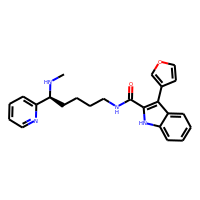
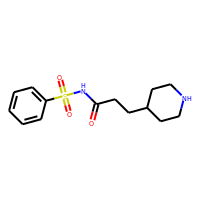
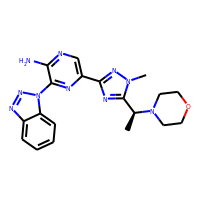

In [8]:
publicWithDescriptors.head(3)

In [9]:
def getResultsValidation(dataframe, k, rf_method_nonkallisto, rf_method, best_columns):
    newColumns = best_columns.insert(0,'RetentionTime')
    newdataframe = dataframe[newColumns[0:k+3]]

    features_df_method = newdataframe.drop(['RetentionTime'], axis = 1)
    features_df_method_nonkallisto = features_df_method.copy()

    features_df_method = features_df_method.iloc[: , :-2]
    features_df_method_nonkallisto.drop(['MolPol', 'IES'], axis=1, inplace=True)
    
    feature_list_method = list(features_df_method.columns)

    features_method_np = np.array(features_df_method)

    features_method_nonkallisto_np = np.array(features_df_method_nonkallisto)

    labels_method = np.array(newdataframe['RetentionTime'])
    
    #train_features_method, test_features_method, train_labels_method, test_labels_method = train_test_split(features_method_np, labels_method, test_size = 0.2, random_state = 42)
    #train_features_method_nonkallisto, test_features_method_nonkallisto, train_labels_method_nonkallisto, test_labels_method_nonkallisto = train_test_split(features_method_nonkallisto_np, labels_method, test_size = 0.2, random_state = 42)

    test_features_method = features_method_np
    test_labels_method = labels_method
    test_features_method_nonkallisto = features_method_nonkallisto_np
    test_labels_method_nonkallisto = labels_method
    

    predictions_method = rf_method.predict(test_features_method)
    # Calculate the absolute errors
    errors_method = predictions_method - test_labels_method

    predictions_method_nonkallisto = rf_method_nonkallisto.predict(test_features_method_nonkallisto)
    # Calculate the absolute errors
    errors_method_nonkallisto = predictions_method_nonkallisto - test_labels_method_nonkallisto
    
    return errors_method_nonkallisto, errors_method, features_df_method

def getPerformance(errors_method_nonkallisto, errors_method, isTraining, methodName):
    kallistoMean = round(np.mean(abs(np.array(errors_method))), 3)
    nonKallistoMean = round(np.mean(abs(np.array(errors_method_nonkallisto))), 3)

    kallistoRmse = round(np.sqrt(np.mean(np.array(errors_method)**2)), 3)
    nonKallistoRmse = round(np.sqrt(np.mean(np.array(errors_method_nonkallisto)**2)), 3)
    
    if isTraining:
        dataType = 'Training'
    else:
        dataType = 'Validation'
    
    print('Mean RF Error', dataType, ':', kallistoMean, 'seconds.')
    print('Mean RF Error nonKallisto', dataType, ':', nonKallistoMean, 'seconds.')

    print('RMSE for method', dataType,':',methodName, kallistoRmse, 'seconds.')
    print('RMSE for nonKallisto method', dataType,':', methodName, nonKallistoRmse, 'seconds.')

    print('Improvement in', dataType, 'MSE is', np.round((nonKallistoMean - kallistoMean)/nonKallistoMean*100,2))
    print('Improvement in', dataType, 'RMSE is', np.round((nonKallistoRmse-kallistoRmse)/nonKallistoRmse*100,2))
    
    return np.round((nonKallistoMean - kallistoMean)/nonKallistoMean*100,2)



In [10]:
TotalErrors = pd.DataFrame({})
errorList = []

In [11]:
%%time
## 'SFC-4'
# training data
methodName = 'EP_NH3_2'
k = 65

rf_method_nonkallisto = joblib.load("Model/rfModelSFCEPNonKallisto.joblib")
rf_method = joblib.load("Model/rfModelSFCEP.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, bestFeatures)
errorList.insert(0,getPerformance(errors_method_nonkallisto, errors_method, False, methodName))

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)

There are 502 data points in the validation dataset
Mean RF Error Validation : 14.514 seconds.
Mean RF Error nonKallisto Validation : 15.964 seconds.
RMSE for method Validation : EP_NH3_2 21.02 seconds.
RMSE for nonKallisto method Validation : EP_NH3_2 22.626 seconds.
Improvement in Validation MSE is 9.08
Improvement in Validation RMSE is 7.1
CPU times: user 72.9 ms, sys: 2.95 ms, total: 75.9 ms
Wall time: 76.1 ms


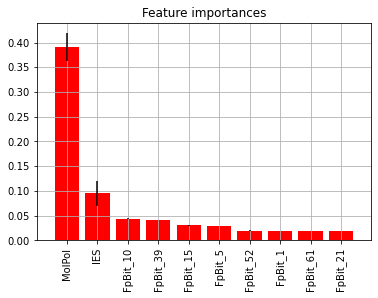

In [12]:
importances_method = rf_method.feature_importances_
std_method = np.std([tree.feature_importances_ for tree in rf_method.estimators_], axis=0)
indices_method = np.argsort(importances_method)[::-1]
features_df_method.columns[indices_method[0:50]]

k = 10
plt.figure()
plt.title("Feature importances")
plt.bar(range(k), importances_method[indices_method[0:k]],
        color="r", yerr=std_full[indices_method[0:k]], align="center")
plt.xticks(range(k), features_df.columns[indices_method[0:k]], rotation='vertical')
plt.xlim([-1, k])
plt.savefig('Output/AZImportances.pdf')
plt.grid(True)

plt.show()

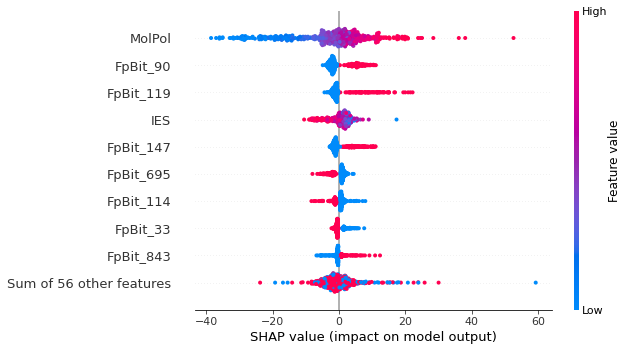

In [13]:
fig = plt.figure()
explainer = shap.Explainer(rf_method)
shap_values = explainer(features_df_method)
shap.plots.beeswarm(shap_values, show=False)
                    
plt.savefig('Output/SHAPImportances.pdf',dpi = 150,bbox_inches = 'tight')

In [14]:
%%time
## 'SFC-3'
# training data
methodName = 'Luna_NH3_1'
k = 60

rf_method_nonkallisto = joblib.load("Model/rfModelSFCLunaNonKallisto.joblib")
rf_method = joblib.load("Model/rfModelSFCLuna.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, bestFeatures)
errorList.insert(0,getPerformance(errors_method_nonkallisto, errors_method, False, methodName))

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)


There are 495 data points in the validation dataset
Mean RF Error Validation : 18.099 seconds.
Mean RF Error nonKallisto Validation : 20.238 seconds.
RMSE for method Validation : Luna_NH3_1 25.111 seconds.
RMSE for nonKallisto method Validation : Luna_NH3_1 27.738 seconds.
Improvement in Validation MSE is 10.57
Improvement in Validation RMSE is 9.47
CPU times: user 76.3 ms, sys: 1.98 ms, total: 78.3 ms
Wall time: 78.5 ms


In [15]:
%%time
## 'SFC-2'
# training data
methodName = 'BEH_NH3_H2O_B2_4'
k = 110

rf_method_nonkallisto = joblib.load("Model/rfModelSFCBEHH20NonKallisto.joblib")
rf_method = joblib.load("Model/rfModelSFCBEHH20.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, bestFeatures)
errorList.insert(0,getPerformance(errors_method_nonkallisto, errors_method, False, methodName))

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)

There are 227 data points in the validation dataset
Mean RF Error Validation : 19.175 seconds.
Mean RF Error nonKallisto Validation : 21.344 seconds.
RMSE for method Validation : BEH_NH3_H2O_B2_4 27.845 seconds.
RMSE for nonKallisto method Validation : BEH_NH3_H2O_B2_4 29.569 seconds.
Improvement in Validation MSE is 10.16
Improvement in Validation RMSE is 5.83
CPU times: user 66 ms, sys: 3.96 ms, total: 69.9 ms
Wall time: 70.1 ms


In [16]:
%%time
## 'SFC-1'
# training data
methodName = 'BEH_NH3_3'
k = 65

rf_method_nonkallisto = joblib.load("Model/rfModelSFCBEHNonKallisto.joblib")
rf_method = joblib.load("Model/rfModelSFCBEH.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, bestFeatures)
errorList.insert(0,getPerformance(errors_method_nonkallisto, errors_method, False, methodName))

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)

There are 487 data points in the validation dataset
Mean RF Error Validation : 20.153 seconds.
Mean RF Error nonKallisto Validation : 19.392 seconds.
RMSE for method Validation : BEH_NH3_3 28.734 seconds.
RMSE for nonKallisto method Validation : BEH_NH3_3 27.908 seconds.
Improvement in Validation MSE is -3.92
Improvement in Validation RMSE is -2.96
CPU times: user 71 ms, sys: 9.93 ms, total: 80.9 ms
Wall time: 156 ms


In [17]:
%%time
## 'LC-2'
# training data
methodName = 'Standard_3min_col3_sur'
k = 60

rf_method_nonkallisto = joblib.load("Model/rfModelLCSurNonKallisto.joblib")
rf_method = joblib.load("Model/rfModelLCSur.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, bestFeatures)
errorList.insert(0,getPerformance(errors_method_nonkallisto, errors_method, False, methodName))

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)

There are 851 data points in the validation dataset
Mean RF Error Validation : 14.491 seconds.
Mean RF Error nonKallisto Validation : 14.828 seconds.
RMSE for method Validation : Standard_3min_col3_sur 19.973 seconds.
RMSE for nonKallisto method Validation : Standard_3min_col3_sur 20.576 seconds.
Improvement in Validation MSE is 2.27
Improvement in Validation RMSE is 2.93
CPU times: user 84.6 ms, sys: 5.98 ms, total: 90.6 ms
Wall time: 90.8 ms


In [18]:
%%time
## 'LC-1'
# training data
methodName = 'Standard_3min_col2_alk'
k = 100

rf_method_nonkallisto = joblib.load("Model/rfModelLCAlkNonKallisto.joblib")
rf_method = joblib.load("Model/rfModelLCAlk.joblib")

newDf = publicWithDescriptors.loc[groupsvalidation.groups[methodName]]
print('There are', newDf.shape[0],'data points in the validation dataset')

errors_method_nonkallisto, errors_method, features_df_method = getResultsValidation(newDf, k, rf_method_nonkallisto, rf_method, bestFeatures)
errorList.insert(0,getPerformance(errors_method_nonkallisto, errors_method, False, methodName))

method = pd.Series(['With Kallisto'])
methodNon = pd.Series(['Without Kallisto'])

siz = errors_method.shape[0]
methodNameSe = pd.Series(methodName).repeat(siz)


errorKallisto = np.vstack([errors_method, method.repeat(siz), methodNameSe]).T
errorKallistoNon = np.vstack([errors_method_nonkallisto, methodNon.repeat(siz), methodNameSe]).T

dfErrors = pd.DataFrame(data=errorKallisto)
dfErrorsKallisto = pd.DataFrame(data=errorKallistoNon)

Errors = pd.concat([dfErrors, dfErrorsKallisto], axis=0, ignore_index=True)

Errors = Errors.rename(columns={0:"errors", 1:"feature type", 2:"method name"})
Errors = Errors.astype({'errors': 'float'})

TotalErrors = pd.concat([Errors, TotalErrors], axis=0, ignore_index=True)


There are 875 data points in the validation dataset
Mean RF Error Validation : 14.478 seconds.
Mean RF Error nonKallisto Validation : 15.492 seconds.
RMSE for method Validation : Standard_3min_col2_alk 20.904 seconds.
RMSE for nonKallisto method Validation : Standard_3min_col2_alk 21.681 seconds.
Improvement in Validation MSE is 6.55
Improvement in Validation RMSE is 3.58
CPU times: user 80.5 ms, sys: 5.92 ms, total: 86.4 ms
Wall time: 167 ms


In [19]:
xposlist = range(len(errorList))
yposlist = np.zeros(len(errorList))-70


In [20]:
TotalErrors.loc[TotalErrors['method name'] == 'EP_NH3_2','method name'] = 'SFC-4'
TotalErrors.loc[TotalErrors['method name'] == 'Luna_NH3_1','method name'] = 'SFC-3'
TotalErrors.loc[TotalErrors['method name'] == 'BEH_NH3_H2O_B2_4','method name'] = 'SFC-2'
TotalErrors.loc[TotalErrors['method name'] == 'BEH_NH3_3','method name'] = 'SFC-1'
TotalErrors.loc[TotalErrors['method name'] == 'Standard_3min_col3_sur','method name'] = 'LC-2'
TotalErrors.loc[TotalErrors['method name'] == 'Standard_3min_col2_alk','method name'] = 'LC-1'



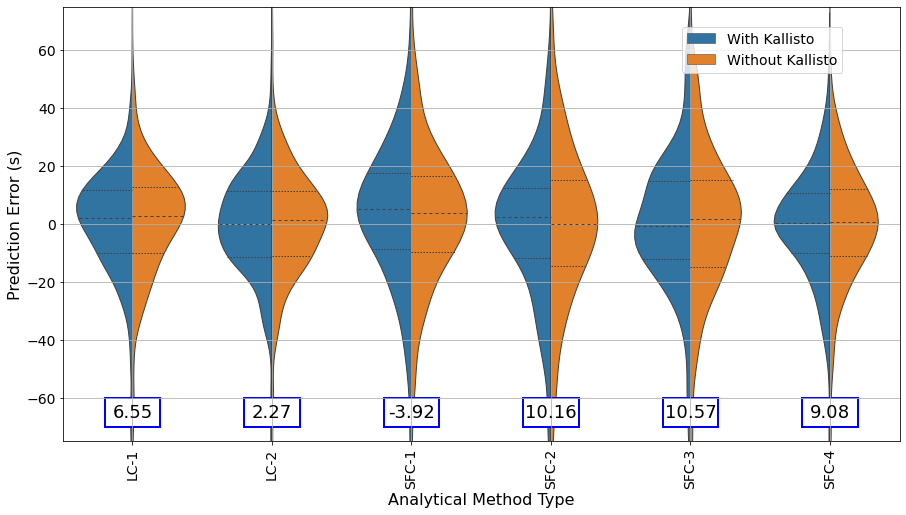

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt, patches

#sns.violinplot(data=Errors, y="errors", hue="feature type",
#               split=True, inner="quart", linewidth=1,
#               palette={"Yes": "b", "No": ".85"})

#sns.violinplot(data = Errors, y = 'errors')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15,8)
sns.violinplot(data = TotalErrors, x="method name", y ='errors', hue='feature type', split=True,  inner="quart", linewidth=1)
ax.tick_params(axis='x', rotation=90)
plt.ylim(-75, 75)
plt.grid(True)


for i in range(len(errorList)):
    #ax.text(xposlist[i], yposlist[i], stringlist[i], fontsize='xx-large', rectangle=dict( boxstyle='square', fc="w", ec=(0., 0.5, 1.)))
    rectangle = patches.Rectangle((-0.2 + xposlist[i], -70), 0.4, 10, edgecolor='blue', facecolor="white", linewidth=2)

    ax.add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry + rectangle.get_height()/2.0
    ax.annotate(errorList[i], (cx, cy), color='black', fontsize=18, ha='center', va='center')
    plt.xticks(fontsize= 14 )
    plt.yticks(fontsize= 14 )
    plt.ylabel("Prediction Error (s)", fontsize=16)
    plt.xlabel("Analytical Method Type", fontsize=16)

    plt.legend(bbox_to_anchor = [0.94, 0.97], prop={'size': 14})



sns.set_style("whitegrid")
plt.savefig('Output/violinplot.pdf')


## Performance vs number of features

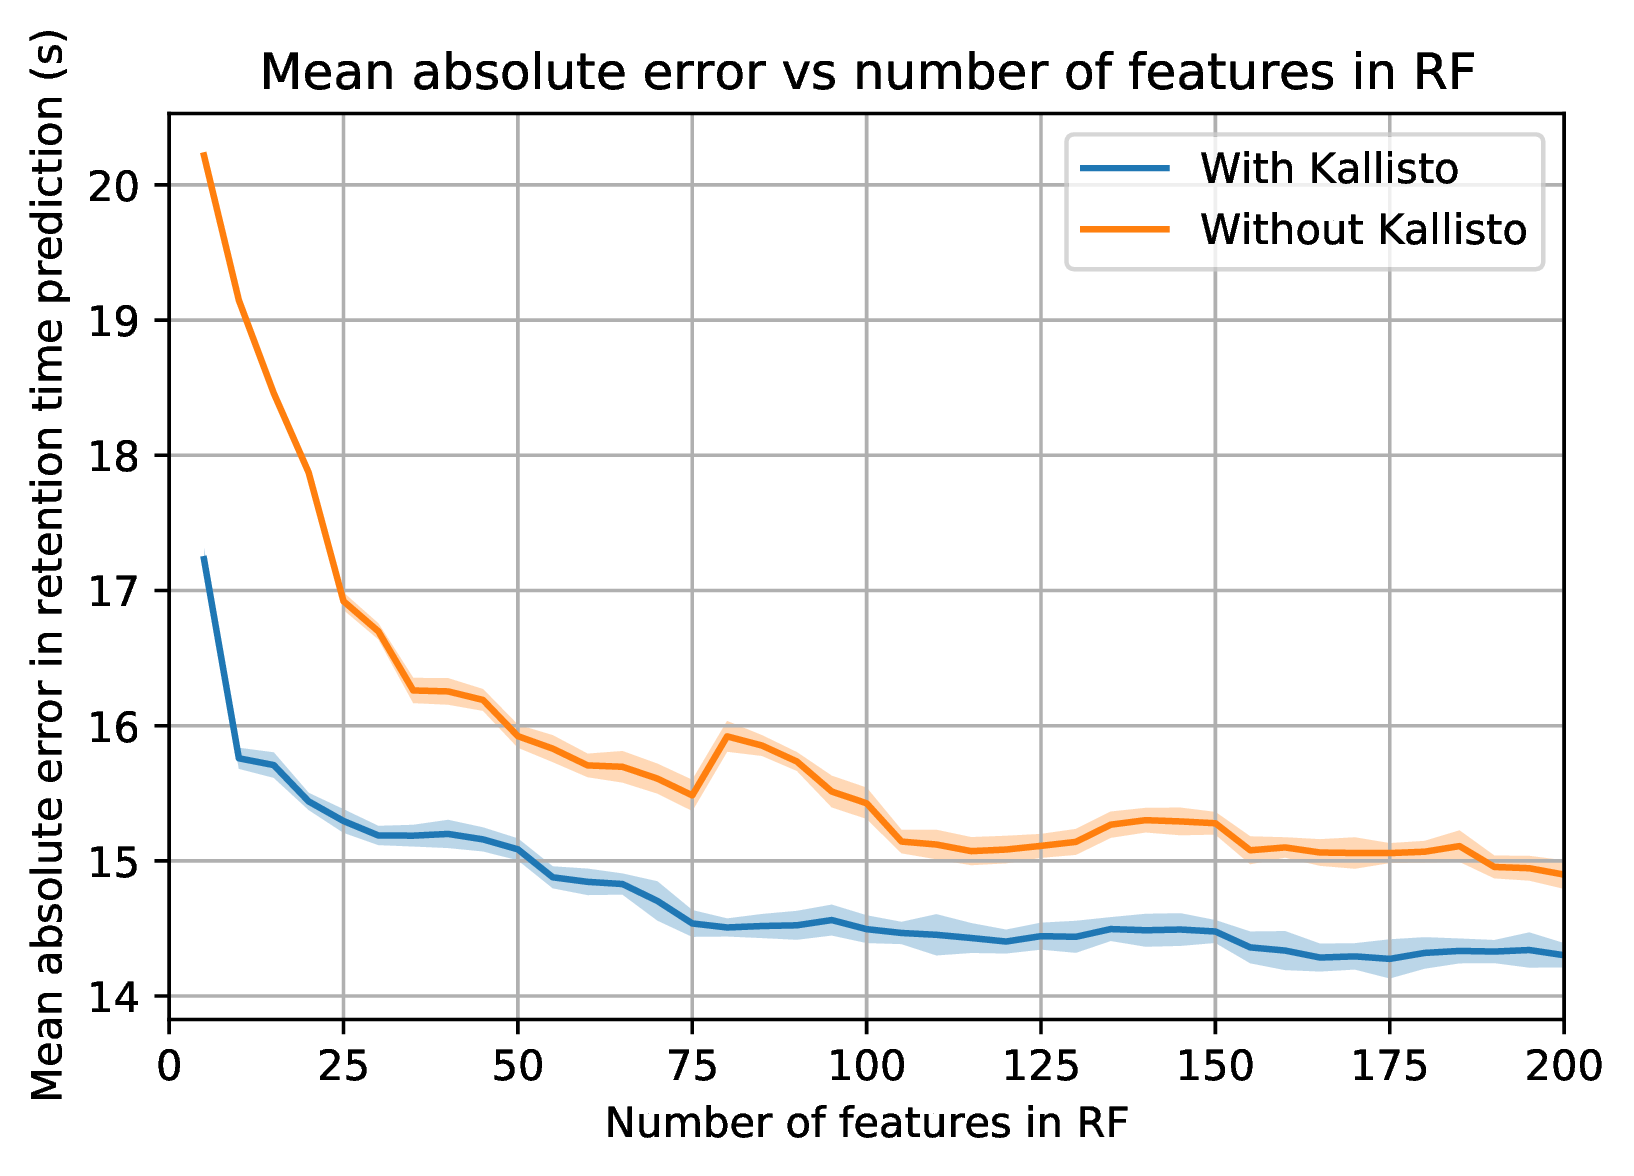

In [22]:
from IPython.display import Image
# LC-1
fig = Image(filename=('Output/ErrorvsFeaturesLC1.png'))
fig

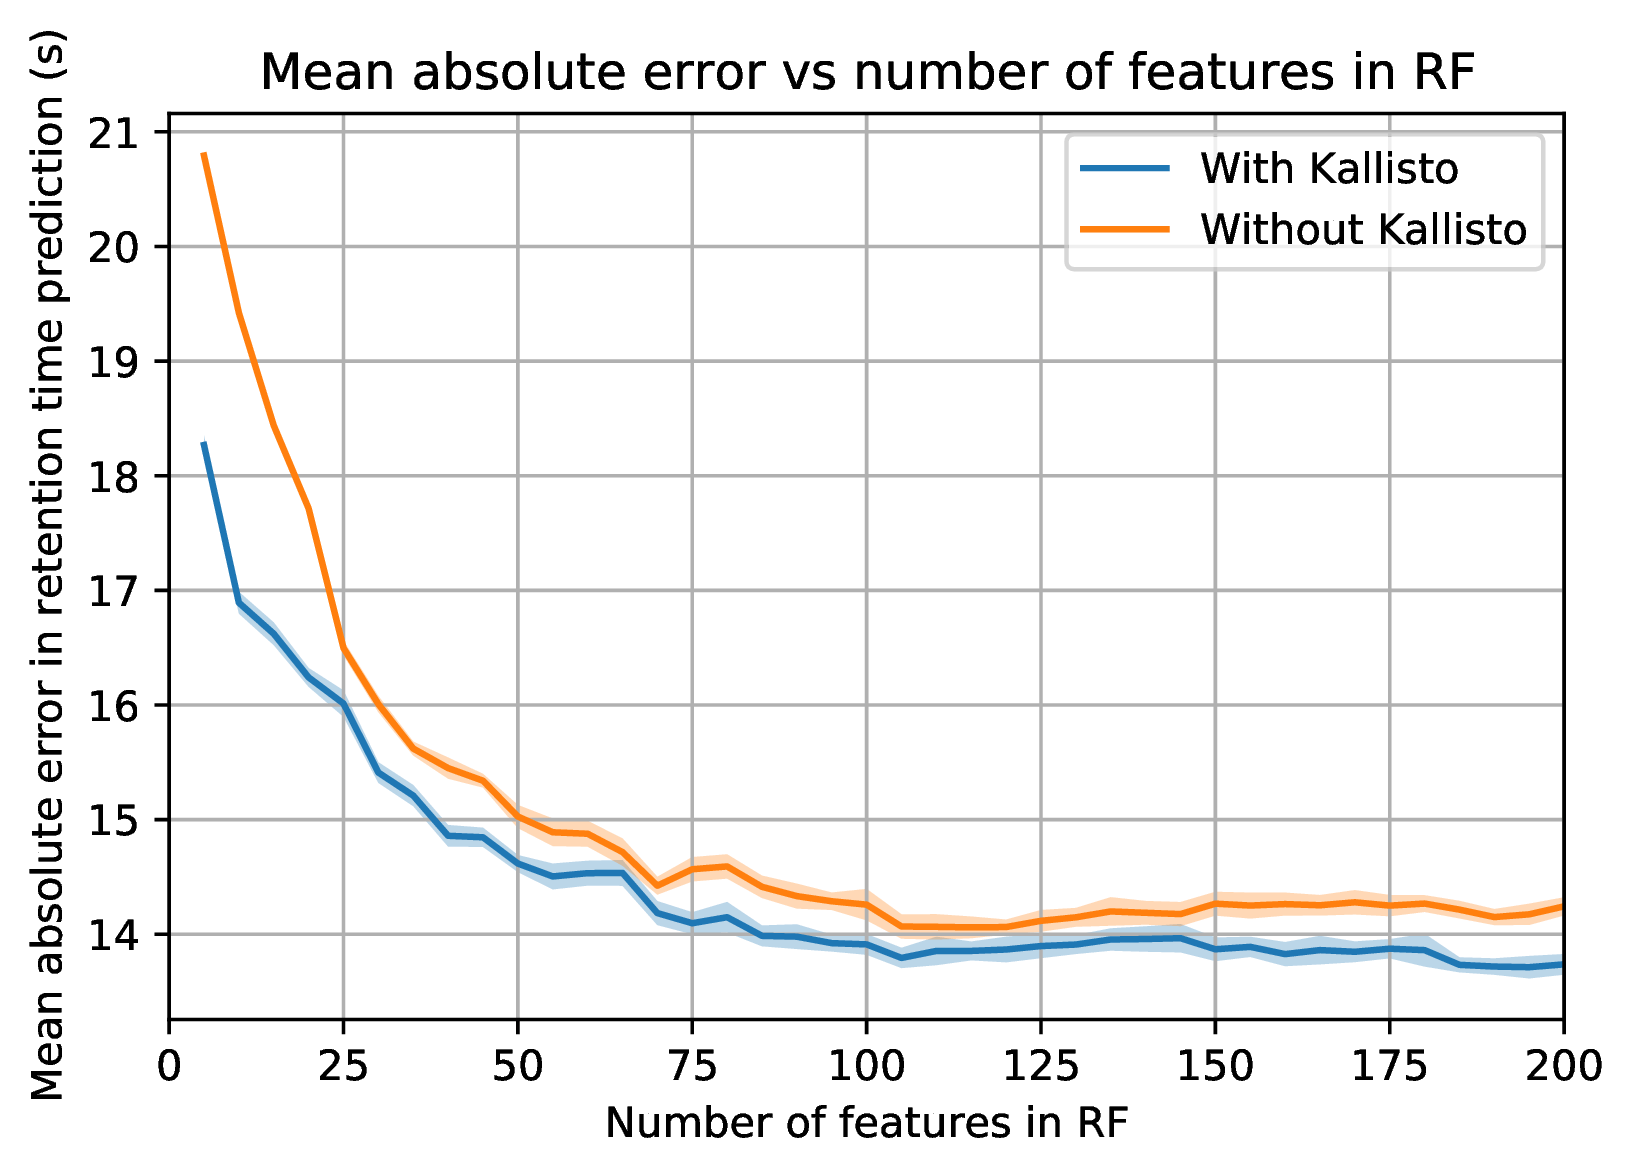

In [23]:
# LC-2
fig = Image(filename=('Output/ErrorvsFeaturesLC2.png'))
fig

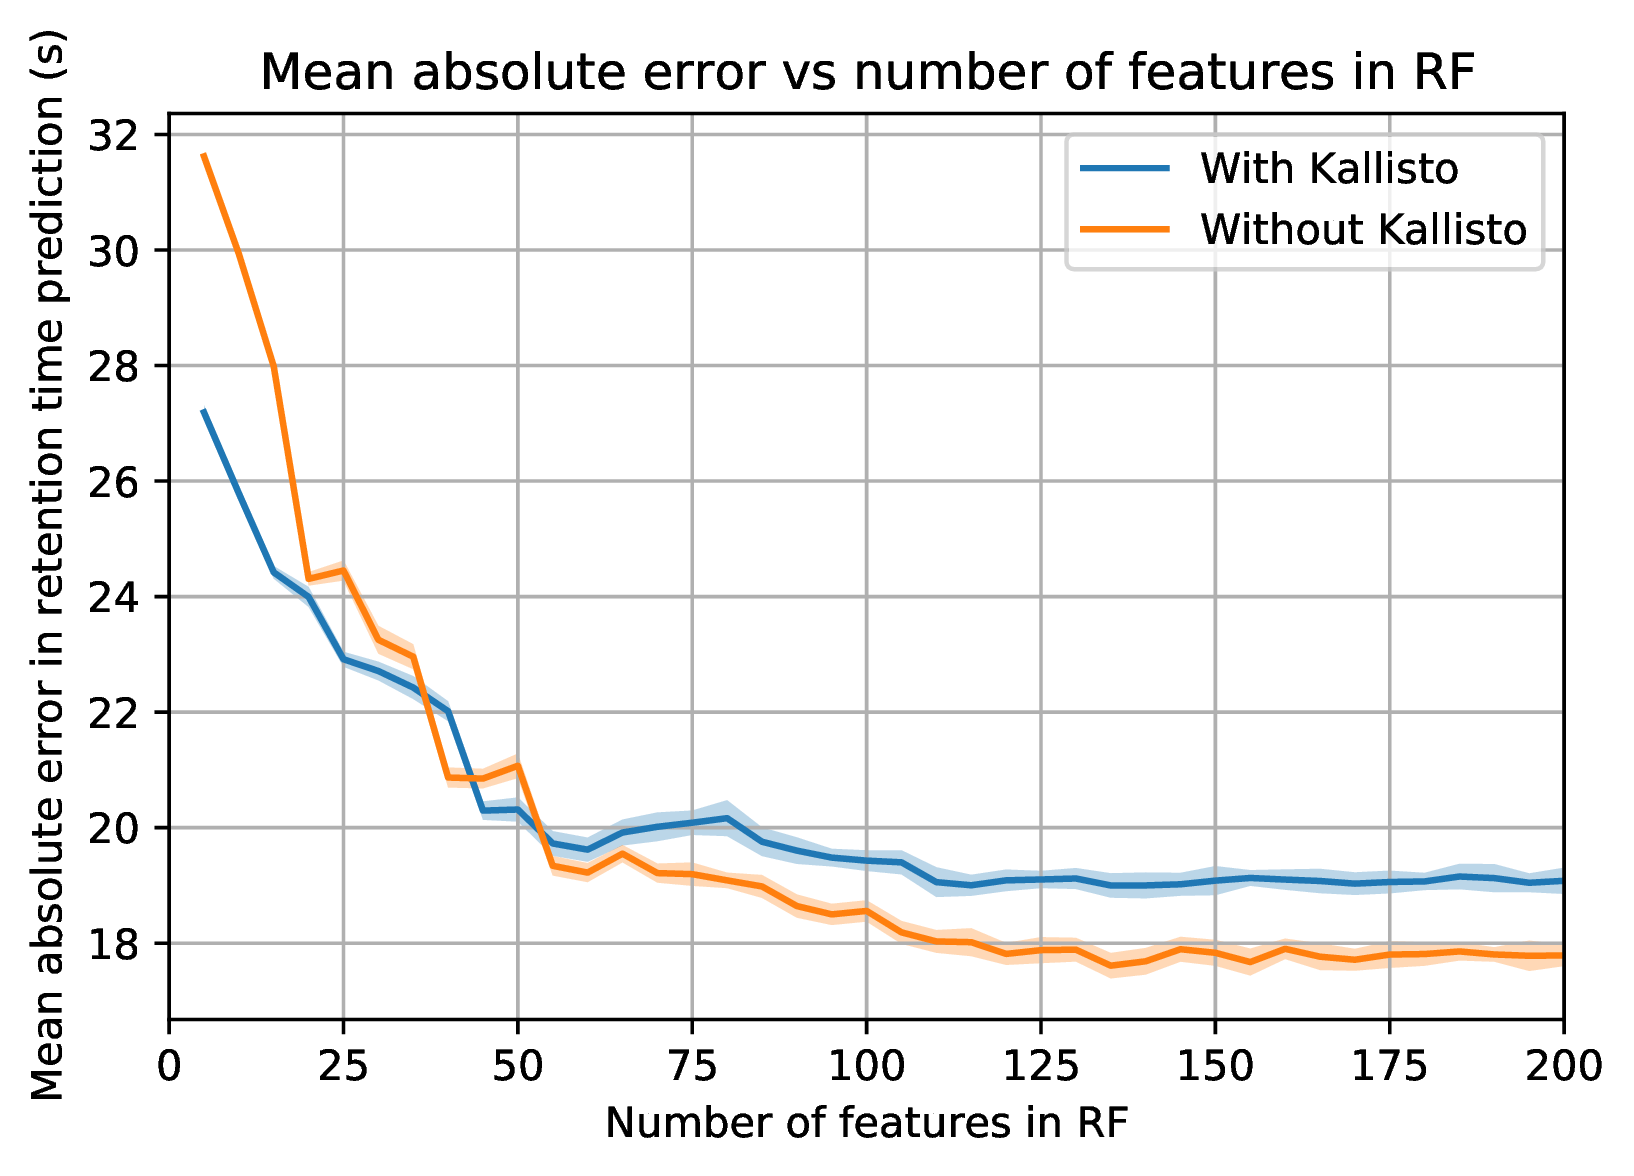

In [24]:
# SFC-1
fig = Image(filename=('Output/ErrorvsFeaturesSFC1.png'))
fig

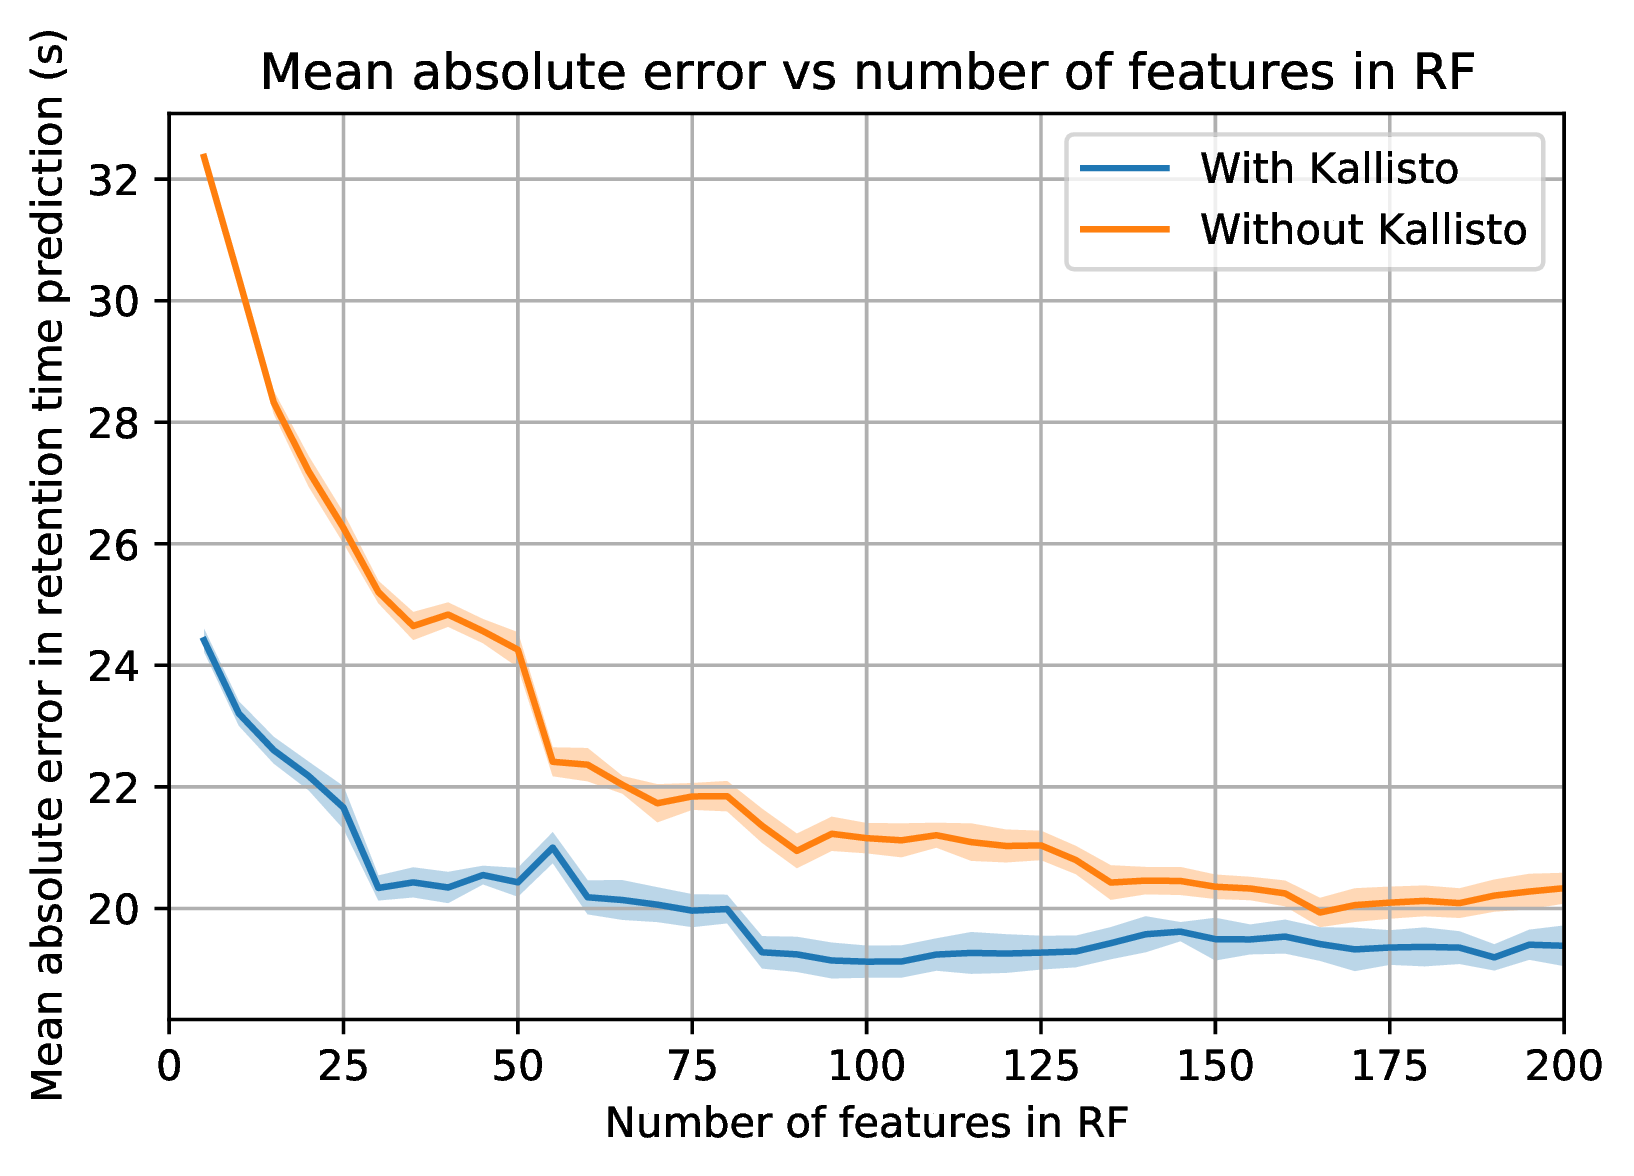

In [25]:
# SFC-2
fig = Image(filename=('Output/ErrorvsFeaturesSFC2.png'))
fig

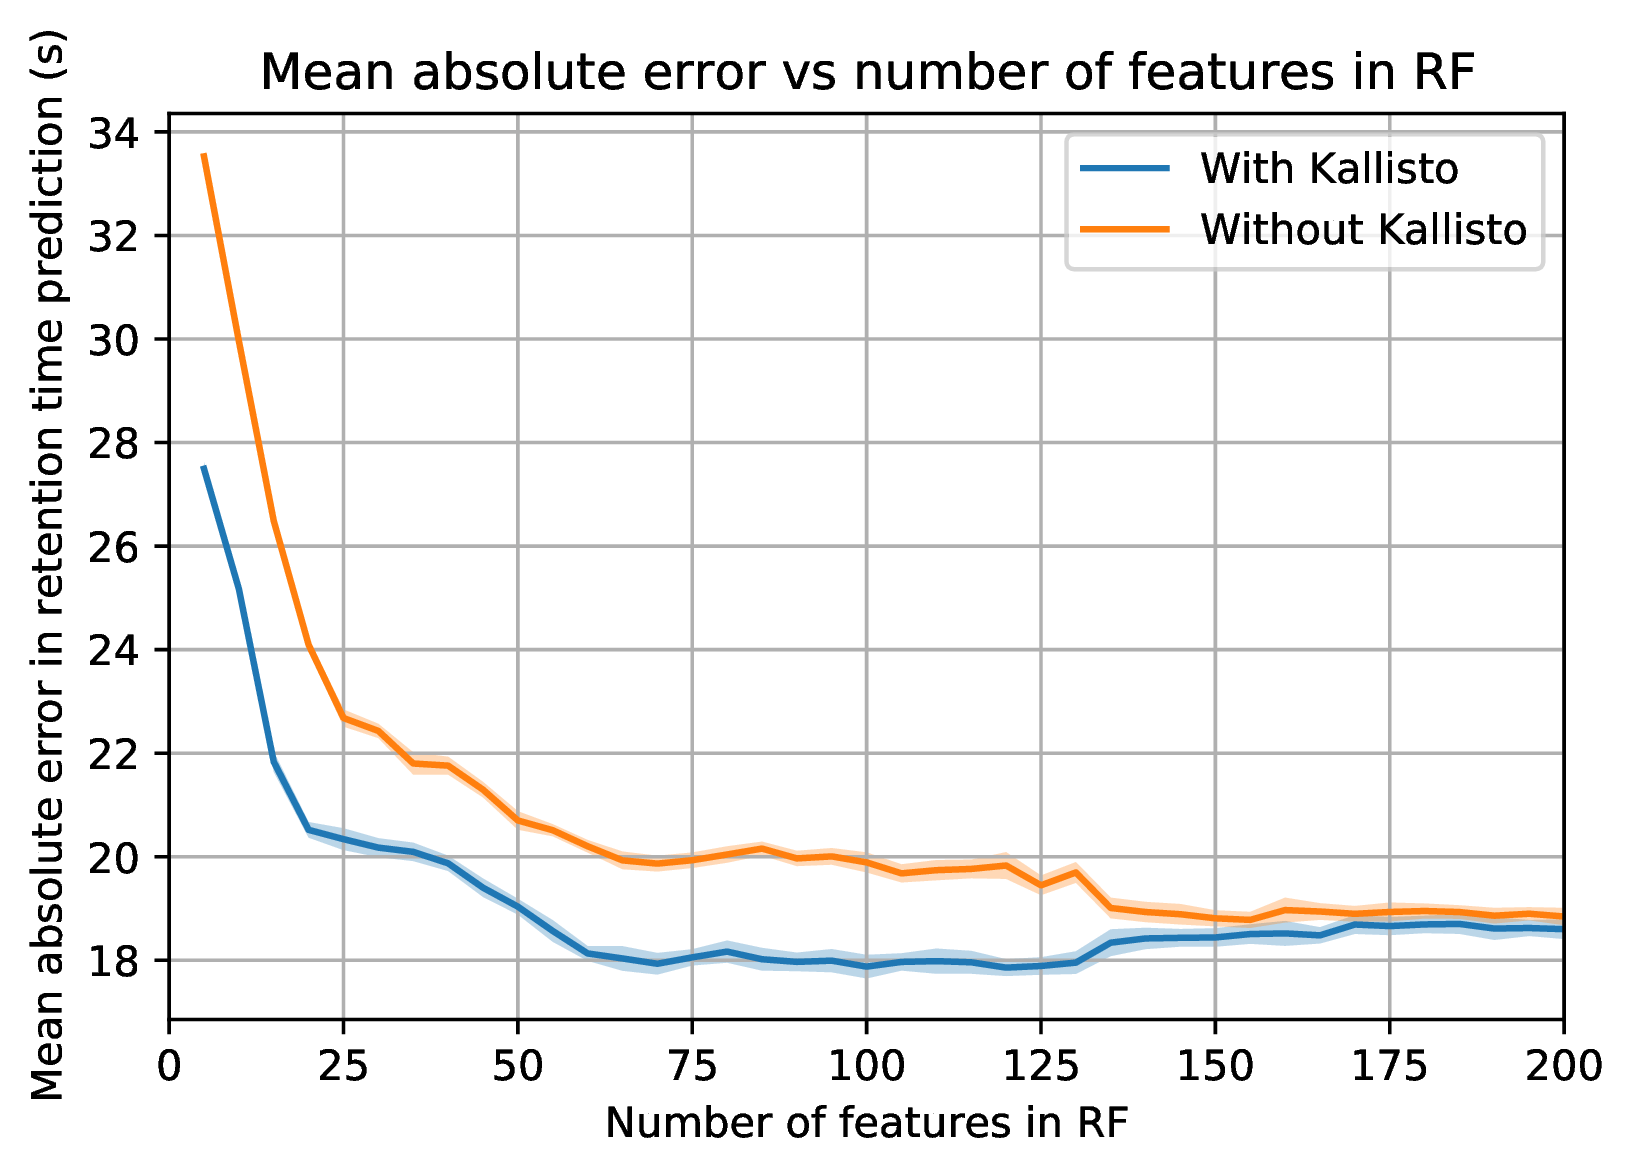

In [26]:
# SFC-3
fig = Image(filename=('Output/ErrorvsFeaturesSFC3.png'))
fig

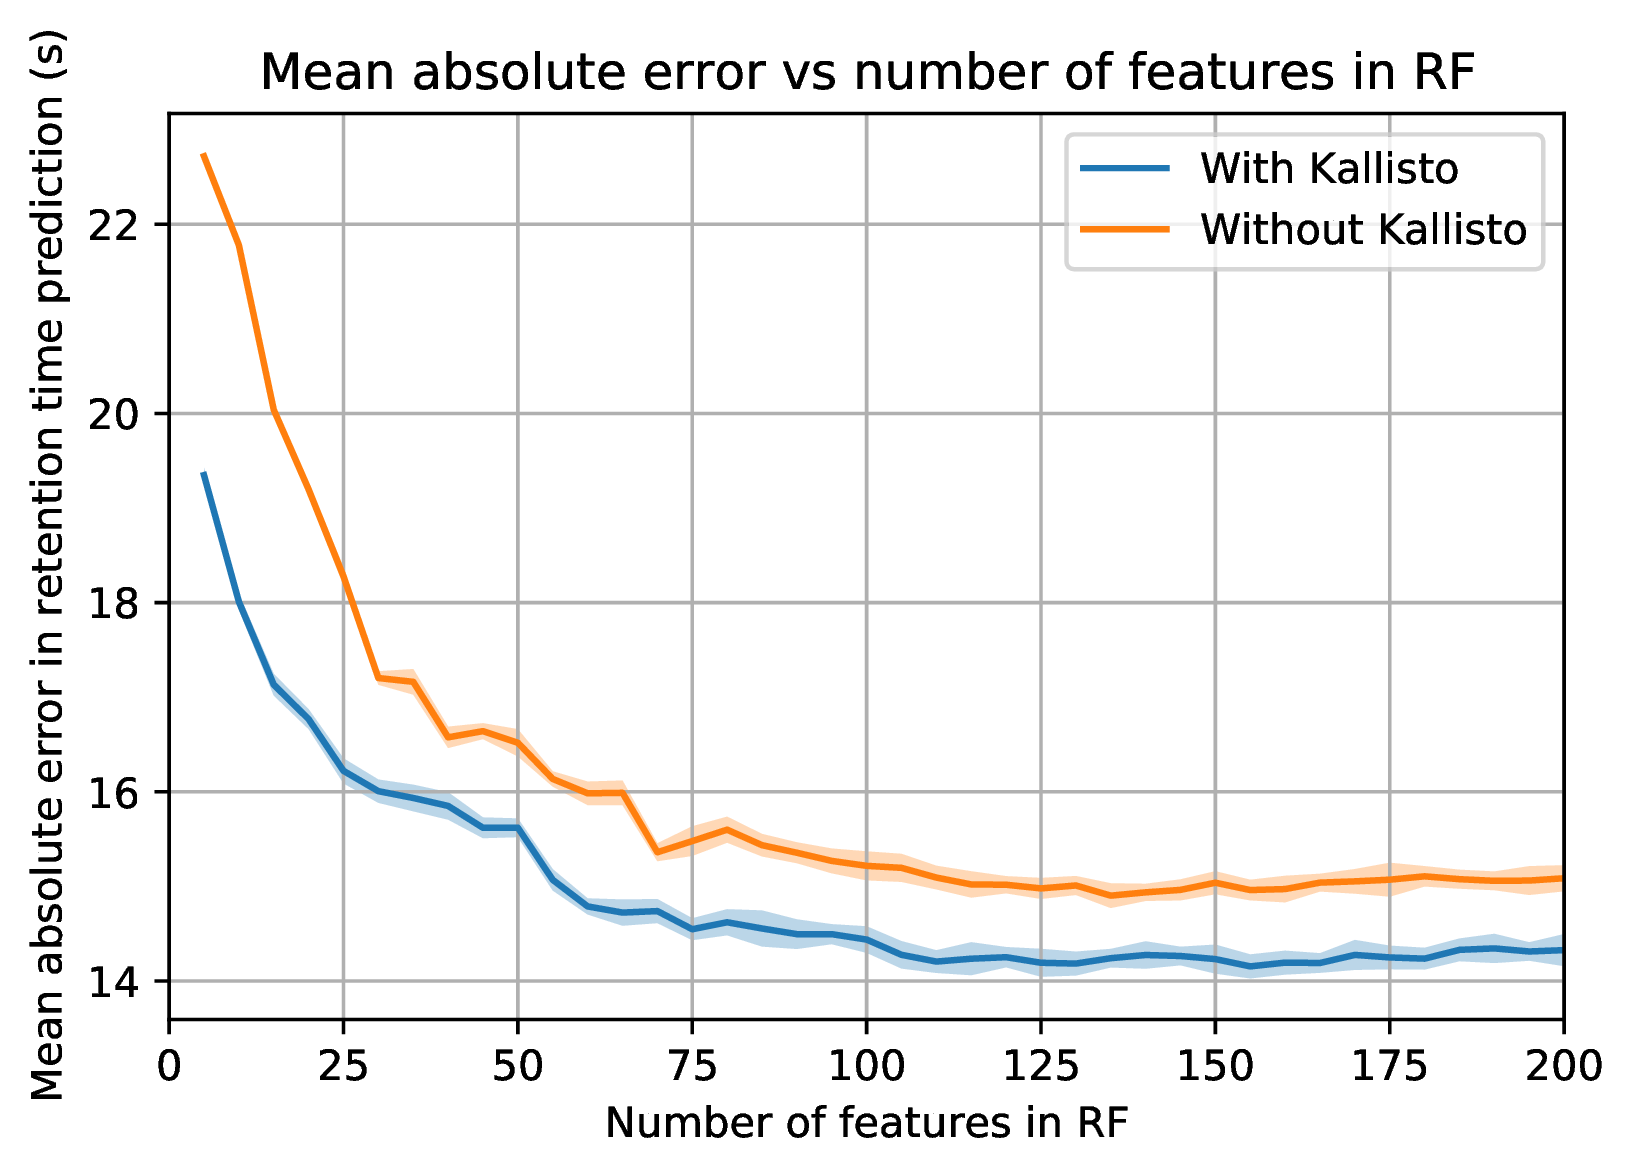

In [27]:
# SFC-4
fig = Image(filename=('Output/ErrorvsFeaturesSFC4.png'))
fig